In [1]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from tqdm import tqdm

from PIL import Image
from torch.utils.data import DataLoader

from deeplab3.config.defaults import get_cfg_defaults
from deeplab3.dataloaders.utils import sample_distribution
from deeplab3.dataloaders.utils import decode_segmap

from deeplab3.dataloaders.datasets.cityscapes import CityscapesSegmentation
from deeplab3.dataloaders.datasets.coco import COCOSegmentation
from deeplab3.dataloaders.datasets.sunrgbd import RGBDSegmentation

from deeplab3.dataloaders.SampleLoader import SampleLoader

In [2]:
def plot_distribution(a_list, bins, percent=False):
    ax = plt.figure()
    bin_middle = np.array([(bins[x] + bins[x + 1]) / 2.0 for x in range(len(bins) - 1)])
    for a in a_list:
        n = np.histogram(a, bins=bins)[0]
        if percent:
            n = n / np.sum(n)
        # y = scipy.stats.norm.pdf(b, 0, 1)
        plt.plot(bin_middle[np.nonzero(n)], n[np.nonzero(n)])

    return ax

In [3]:
def visualize_sample(loader, sample, dataset):
    img_tmp = loader.invert_normalization(sample['image'].squeeze())
    gt = sample['label'].numpy()
    tmp = np.array(gt[0]).astype(np.uint8)
    segmap = decode_segmap(tmp, dataset=dataset)
    
    print(sample['id'])
    plt.figure(figsize=(16, 8))
    
    plt.subplot('141')
    plt.imshow(img_tmp[:,:,:3])
    plt.title('image')
    plt.axis('off')
    
    plt.subplot('142')
    plt.imshow(img_tmp[:,:,3:].squeeze())
    plt.title('depth')
    plt.axis('off')
    
    plt.subplot('143')
    plt.imshow(segmap)
    plt.title('labels')
    plt.axis('off')

Load configuation files for all datasets

In [4]:
sunrgbd_rgbd = get_cfg_defaults()
sunrgbd_rgbd.merge_from_file('../configs/sunrgbd.yaml')
sunrgbd_rgbd.merge_from_list(['DATASET.ROOT', '../datasets/SUNRGBD/'])

coco_synth = get_cfg_defaults()
coco_synth.merge_from_file('../configs/coco_rgbd.yaml')
coco_synth.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

# Coarse labels not available for test set
city_rgbd = get_cfg_defaults()
city_rgbd.merge_from_file('../configs/cityscapes_rgbd.yaml')
city_rgbd.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/']) #, 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

city_synth = get_cfg_defaults()
city_synth.merge_from_file('../configs/cityscapes_synthetic_rgbd.yaml')
city_synth.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/', 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

city_hha = get_cfg_defaults()
city_hha.merge_from_file('../configs/HHA/cityscapes_hha_midfusion.yaml')
city_hha.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/', 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

## Measured (real) Depth Histograms

In [11]:
city_rgbd_dist_train = sample_distribution(CityscapesSegmentation(city_rgbd, split='train_extra'), n=100)
city_rgbd_dist_val = sample_distribution(CityscapesSegmentation(city_rgbd, split='val'), n=100)
city_rgbd_dist_test = sample_distribution(CityscapesSegmentation(city_rgbd, split='train'), n=100)

0it [00:00, ?it/s]

Using RGB-D input
Found 19997 train_extra images


100it [00:39,  2.52it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [00:34,  2.90it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 2975 train images


100it [00:36,  2.72it/s]


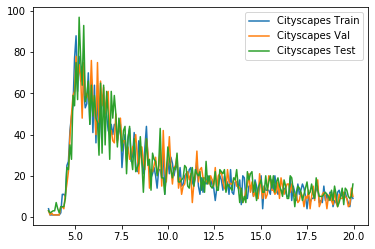

In [6]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples_train = city_depth_samples[np.nonzero(city_depth_samples)]
city_depth_samples = city_rgbd_dist_val['samples'][:, -1]
city_depth_samples_val = city_depth_samples[np.nonzero(city_depth_samples)]
city_depth_samples = city_rgbd_dist_test['samples'][:, -1]
city_depth_samples_test = city_depth_samples[np.nonzero(city_depth_samples)]

bins = np.linspace(-1,20, num=256)
plot_distribution([city_depth_samples_train, 
                   city_depth_samples_val,
                   city_depth_samples_test], bins)
plt.legend(['Cityscapes Train', 'Cityscapes Val', 'Cityscapes Test'])
plt.show()

In [7]:
print("Cityscapes mean: {} \n \t std: {}".format(city_rgbd_dist_train['mean'], 
                                                 city_rgbd_dist_train['std']))

Cityscapes mean: [79.8887     90.2057     79.0167     26.33013559] 
 	 std: [47.50426204 48.59917065 48.68774816 43.52468144]


Using RGB-D input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/jena/jena_000097_000019_leftImg8bit.png']


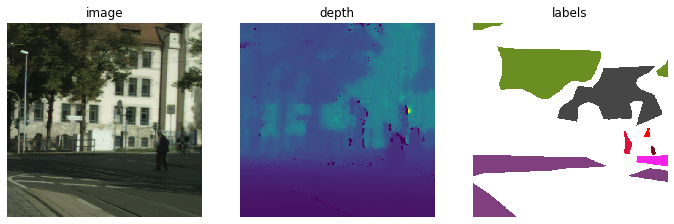

In [10]:
city_val = CityscapesSegmentation(city_rgbd, split='train')
dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_val.loader, sample, 'cityscapes')
    break

In [5]:
sunrgbd_rgbd_dist_train = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='train'), n=100)
sunrgbd_rgbd_dist_val = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='val'), n=100)
sunrgbd_rgbd_dist_test = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='test'), n=100)

loading annotations into memory...
Done (t=0.20s)
creating index...


0it [00:00, ?it/s]

index created!
Using RGB-D input


100it [00:07, 13.23it/s]
0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Using RGB-D input


100it [00:08, 12.30it/s]


loading annotations into memory...


2it [00:00, 14.37it/s]

Done (t=0.27s)
creating index...
index created!
Using RGB-D input


100it [00:07, 13.43it/s]


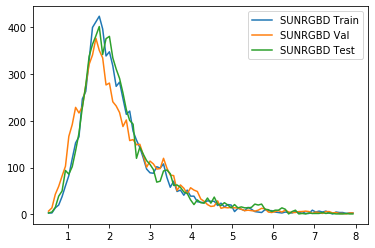

In [6]:
sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples_train = sun_depth_samples[np.nonzero(sun_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_val['samples'][:, -1]
sun_depth_samples_val = sun_depth_samples[np.nonzero(sun_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_test['samples'][:, -1]
sun_depth_samples_test = sun_depth_samples[np.nonzero(sun_depth_samples)]

bins = np.linspace(-1,20, num=256)
plot_distribution([sun_depth_samples_train, 
                   sun_depth_samples_val,
                   sun_depth_samples_test], bins)
plt.legend(['SUNRGBD Train', 'SUNRGBD Val', 'SUNRGBD Test'])
plt.show()

In [7]:
print("SUNRGBD mean: {} \n \t std: {}".format(sunrgbd_rgbd_dist_train['mean'], 
                                                 sunrgbd_rgbd_dist_train['std']))

SUNRGBD mean: [134.1302    131.2473    125.3379      1.7308837] 
 	 std: [67.22704402 69.92115662 68.69923816  1.35110721]


loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Using RGB-D input
tensor([5881])


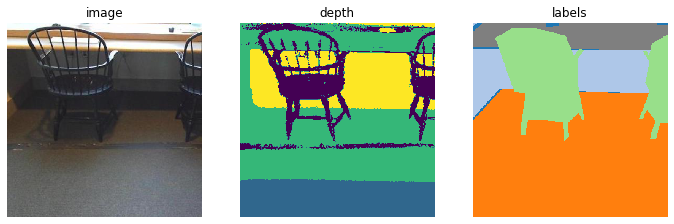

In [8]:
sunrgbd_val = RGBDSegmentation(sunrgbd_rgbd, split='train')
dataloader = DataLoader(sunrgbd_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(sunrgbd_val.loader, sample, 'sunrgbd')
    break

## Cityscapes HHA vs RGB

Comparison between the histogram of the RGB values and the HHA values shows a very different data characteristics that hinder transfer learning

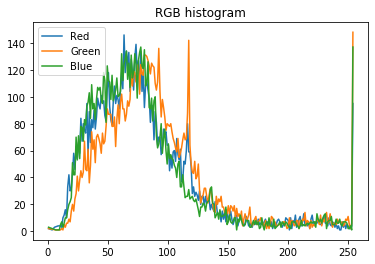

In [12]:
bins = np.linspace(0,255, num=256)
plot_distribution([city_rgbd_dist_train['samples'][:, 0],
                  city_rgbd_dist_train['samples'][:, 1],
                  city_rgbd_dist_train['samples'][:, 2]], bins)
plt.title("RGB histogram")
plt.legend(["Red", "Green", "Blue"])
plt.show()


In [10]:
city_hha_dist_train = sample_distribution(CityscapesSegmentation(city_hha, split='train'), n=100)
city_hha_dist_val = sample_distribution(CityscapesSegmentation(city_hha, split='val'), n=100)
city_hha_dist_test = sample_distribution(CityscapesSegmentation(city_hha, split='test'), n=100)

0it [00:00, ?it/s]

Using RGB HHA input
Found 2975 train images


100it [00:35,  2.83it/s]
0it [00:00, ?it/s]

Using RGB HHA input
Found 500 val images


100it [00:31,  3.21it/s]
0it [00:00, ?it/s]

Using RGB HHA input
Found 1525 test images


100it [00:32,  3.10it/s]


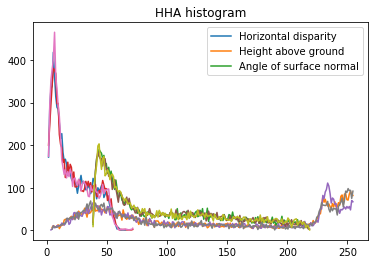

In [13]:
bins = np.linspace(0,255, num=256)

#Train
H1 = city_hha_dist_train['samples'][:,3]
H1_train = H1[np.nonzero(H1)]

H2 = city_hha_dist_train['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_train = H2[H2<255]

A = city_hha_dist_train['samples'][:,5]
A_train = A[np.nonzero(A)]

# Val
H1 = city_hha_dist_val['samples'][:,3]
H1_val = H1[np.nonzero(H1)]

H2 = city_hha_dist_val['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_val = H2[H2<255]

A = city_hha_dist_val['samples'][:,5]
A_val = A[np.nonzero(A)]

#Test
H1 = city_hha_dist_test['samples'][:,3]
H1_test = H1[np.nonzero(H1)]

H2 = city_hha_dist_test['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_test = H2[H2<255]

A = city_hha_dist_test['samples'][:,5]
A_test = A[np.nonzero(A)]


plot_distribution([H1_train, H2_train, A_train,
                  H1_val, H2_val, A_val,
                  H1_test, H2_test, A_test], bins)
plt.title("HHA histogram")
plt.legend(["Horizontal disparity", "Height above ground", "Angle of surface normal"])
plt.show()


In [14]:
print("Cityscapes HHA mean: {} \n \t std: {}".format(city_hha_dist_train['mean'], 
                                                 city_hha_dist_train['std']))

Cityscapes HHA mean: [ 73.822   83.4232  72.9391  16.3307 128.8237  76.1718] 
 	 std: [ 47.07602273  48.10768651  47.14700405  16.10813265 104.04366688
  58.61072329]


Using RGB HHA input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/bochum/bochum_000000_021070_leftImg8bit.png']


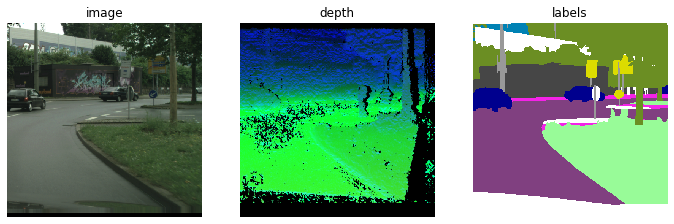

In [15]:
city_hha_val = CityscapesSegmentation(city_hha, split='train')
dataloader = DataLoader(city_hha_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_hha_val.loader, sample, 'cityscapes')
    break

## COCO VNL Monocular Depth Estimation
COCO synthetic depth is generated using a model trained on NYUv2, a dataset of interior scenes. Therefore the estimated depths range between \[0, 12\] meters

In [5]:
coco_synth_dist_train = sample_distribution(COCOSegmentation(coco_synth, split='train'), n=100)
coco_synth_dist_val = sample_distribution(COCOSegmentation(coco_synth, split='val'), n=100)
#coco_synth_dist_test = sample_distribution(COCOSegmentation(coco_synth, split='test'), n=100)

loading annotations into memory...
Done (t=14.49s)
creating index...


0it [00:00, ?it/s]

index created!
Using RGB-D input


11it [00:01,  8.76it/s]

Large max depth: 2219 ../datasets/coco/VNL_Monocular/000000482177.png


15it [00:01,  8.88it/s]

Large max depth: 2330 ../datasets/coco/VNL_Monocular/000000325390.png
Large max depth: 2268 ../datasets/coco/VNL_Monocular/000000193246.png


59it [00:06, 10.80it/s]

Large max depth: 2018 ../datasets/coco/VNL_Monocular/000000369034.png


71it [00:07,  9.81it/s]

Large max depth: 2179 ../datasets/coco/VNL_Monocular/000000298193.png


88it [00:09,  9.22it/s]

Large max depth: 2047 ../datasets/coco/VNL_Monocular/000000455667.png


100it [00:10,  9.31it/s]


loading annotations into memory...


0it [00:00, ?it/s]

Done (t=0.61s)
creating index...
index created!
Using RGB-D input


26it [00:04,  8.87it/s]

Large max depth: 2084 ../datasets/coco/VNL_Monocular/000000105912.png


53it [00:06, 11.27it/s]

Large max depth: 2575 ../datasets/coco/VNL_Monocular/000000539143.png


59it [00:07, 11.43it/s]

Large max depth: 2193 ../datasets/coco/VNL_Monocular/000000133567.png


100it [00:11,  8.95it/s]


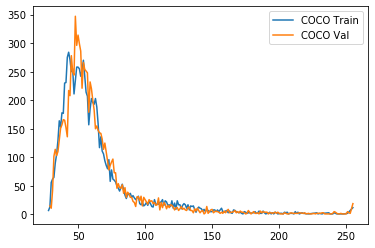

In [6]:
bins = np.linspace(0,256, num=256)
plot_distribution([coco_synth_dist_train['samples'][:, -1], 
                   coco_synth_dist_val['samples'][:, -1]], bins)
                   #coco_synth_dist_test['samples'][:, -1]], bins)
plt.legend(['COCO Train', 'COCO Val'])
plt.show()

In [8]:
print("COCO VNL mean: {} \n \t std: {}".format(coco_synth_dist_train['mean'], 
                                                 coco_synth_dist_train['std']))

COCO VNL mean: [126.6371 116.8534 103.3159  63.4242] 
 	 std: [71.91419473 72.17100878 76.61893961 31.16010357]


loading annotations into memory...
Done (t=14.21s)
creating index...
index created!
Using RGB-D input
tensor([58155])


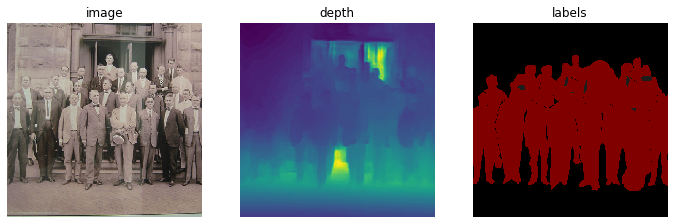

In [9]:
coco_val = COCOSegmentation(coco_synth, split='train')
dataloader = DataLoader(coco_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(coco_val.loader, sample, 'coco')
    break

tensor([21204])


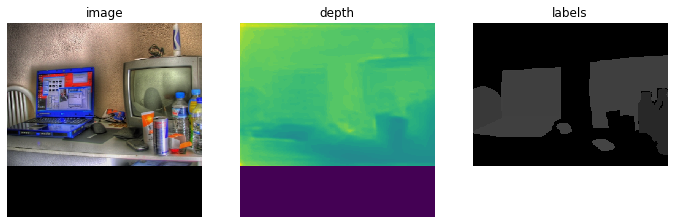

In [10]:
for ii, sample in enumerate(dataloader):
    visualize_sample(coco_val.loader, sample, 'coco')
    break

## Cityscapes VNL Monocular Depth Estimation
Cityscapes synthetic depth is generated using a model trained on KITTI, a dataset for autonomous driving. Therefore the estimated depths range between \[0, 150\] meters

In [5]:
city_synth_dist_train = sample_distribution(CityscapesSegmentation(city_synth, split='train'), n=100)
city_synth_dist_val = sample_distribution(CityscapesSegmentation(city_synth, split='val'), n=100)
city_synth_dist_test = sample_distribution(CityscapesSegmentation(city_synth, split='test'), n=100)

0it [00:00, ?it/s]

Using RGB-D input
Found 2975 train images


100it [00:29,  3.40it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [00:27,  3.69it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 1525 test images


100it [00:27,  3.60it/s]


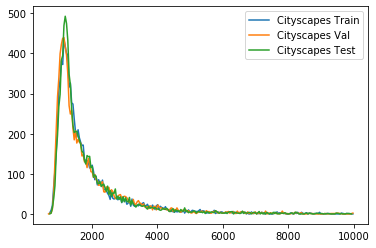

In [9]:
bins = np.linspace(-1,10000, num=256)
plot_distribution([city_synth_dist_train['samples'][:, -1], 
                   city_synth_dist_val['samples'][:, -1],
                   city_synth_dist_test['samples'][:, -1]], bins)
plt.legend(['Cityscapes Train', 'Cityscapes Val', 'Cityscapes Test'])
plt.show()

Using RGB-D input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/hanover/hanover_000000_030276_leftImg8bit.png']


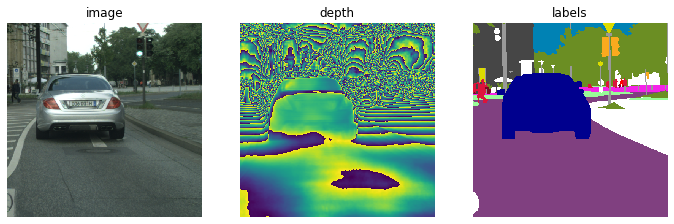

In [7]:
city_synth_val = CityscapesSegmentation(city_synth, split='train')
dataloader = DataLoader(city_synth_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_synth_val.loader, sample, 'cityscapes')
    break

## Comparison of estimated and target distributions
We use the synthetic depth to pretrain segmentation networks for smaller datasets with real depth. The COCO dataset is used to pretrain for segmenting the SUNRGBD dataset. And the Cityscapes dataset is used to experiment with synthetic pretraining on different dataset scales. 

In the following plot, we compare the distributions to show the differences between the pretraining and real depth measurements.

In [ ]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples = city_depth_samples[np.nonzero(city_depth_samples)]

city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples = city_synth_samples[np.nonzero(city_synth_samples)]

coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples = coco_depth_samples[np.nonzero(coco_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples = sun_depth_samples[np.nonzero(sun_depth_samples)]
sun_depth_samples = sun_depth_samples[sun_depth_samples<255]

bins = np.linspace(-1,20, num=256)
plot_distribution([city_depth_samples, sun_depth_samples, 
                   city_synth_samples, coco_depth_samples], bins)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.show()

We normalize the datasets to zero mean and unit std.

In [ ]:
def norm(samples, mean, std):
    return (samples - mean)/std

In [ ]:
print("Cityscapes mean: {} \n \t std: {}".format(city_rgbd_dist_train['mean'], 
                                                 city_rgbd_dist_train['std']))
print("SUNRGBD mean: {} \n \t std: {}".format(sunrgbd_rgbd_dist_train['mean'], 
                                                 sunrgbd_rgbd_dist_train['std']))
print("Cityscapes VNL mean: {} \n \t std: {}".format(city_synth_dist_train['mean'], 
                                                 city_synth_dist_train['std']))
print("COCO VNL mean: {} \n \t std: {}".format(coco_synth_dist_train['mean'], 
                                                 coco_synth_dist_train['std']))

In [ ]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples = norm(city_depth_samples[np.nonzero(city_depth_samples)], 
                          city_rgbd_dist_train['mean'][-1], city_rgbd_dist_train['std'][-1])

city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples = norm(city_synth_samples[np.nonzero(city_synth_samples)], 
                          city_synth_dist_train['mean'][-1], city_synth_dist_train['std'][-1])

coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples = norm(coco_depth_samples[np.nonzero(coco_depth_samples)], 
                          coco_synth_dist_train['mean'][-1], coco_synth_dist_train['std'][-1])

sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples = sun_depth_samples[np.nonzero(sun_depth_samples)]
sun_depth_samples = norm(sun_depth_samples[sun_depth_samples<255], 
                         sunrgbd_rgbd_dist_train['mean'][-1], sunrgbd_rgbd_dist_train['std'][-1])

bins = np.linspace(-1,20, num=256)
plot_distribution([city_depth_samples, sun_depth_samples, 
                   city_synth_samples, coco_depth_samples], bins, percent=True)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.xlim(right=2)
plt.show()

## Experiments with Box Cox

In [ ]:
import scipy.stats

city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples_cox = scipy.stats.boxcox(city_depth_samples[np.nonzero(city_depth_samples)], -0.5)
city_depth_samples_cox = norm(city_depth_samples_cox, np.mean(city_depth_samples_cox), np.std(city_depth_samples_cox))


city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples_cox = scipy.stats.boxcox(city_synth_samples[np.nonzero(city_synth_samples)], -0.5)
city_synth_samples_cox = norm(city_synth_samples_cox, np.mean(city_synth_samples_cox), np.std(city_synth_samples_cox))


coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples_cox = scipy.stats.boxcox(coco_depth_samples[np.nonzero(coco_depth_samples)], -0.5)
coco_depth_samples_cox = norm(coco_depth_samples_cox, np.mean(coco_depth_samples_cox), np.std(coco_depth_samples_cox))


sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples_cox = scipy.stats.boxcox(sun_depth_samples[np.nonzero(sun_depth_samples)], -0.5)
sun_depth_samples_cox = norm(sun_depth_samples_cox, np.mean(sun_depth_samples_cox), np.std(sun_depth_samples_cox))


bins = np.linspace(-1,20, num=256)
plot_distribution([city_depth_samples_cox, sun_depth_samples_cox, 
                   city_synth_samples_cox, coco_depth_samples_cox], bins)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.show()